## Human review with A2i


In this section we will implement a human review loop that will classify claims that fall within the uncertainty range.

# Setup
first we will set up the dependencies.

In [5]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install botocore --upgrade
!pip install boto3 --upgrade
!pip install -U botocore

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for botocore from https://files.pythonhosted.org/packages/14/36/af5c6f6742773063d6729de739d331f5ed16a034a72242351868cc181e72/botocore-1.31.19-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 116.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.157 requires botocore==1.29.157, but you have botocore 1.31.19 which is incompatible.
sagemaker 2.167.0 requires PyYAML==6.0, but you have pyyaml 5.4.1 which is incompatible.
Looking in i

In [6]:
import boto3
import botocore

REGION = 'us-east-2'
boto3.session.Session(REGION)

Session(region_name='us-east-2')

In [7]:
# Replace the following with your bucket name
BUCKET = 'project-a2i-output'

In [8]:
# Amazon S3 (S3) client
s3 = boto3.client('s3', REGION)
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == REGION, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

In [9]:
from sagemaker import get_execution_role

# Setting Role to the default SageMaker Execution Role
ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::767819814815:role/service-role/SageMaker-gmonieProject'

# create your Workteam in the console
Once created enter work team ARN below.

In [10]:
WORKTEAM_ARN = "arn:aws:sagemaker:us-east-2:767819814815:workteam/private-crowd/fraudetection-team"

## setup client

In [11]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
import json
import uuid 
from datetime import datetime
import io

# -- Client setup -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline

/tmp/ipykernel_1882/2359204613.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [12]:
import pprint

# Pretty print setup
pp = pprint.PrettyPrinter(indent=2)

# Function to pretty-print AWS SDK responses
def print_response(response):
    if 'ResponseMetadata' in response:
        del response['ResponseMetadata']
    pp.pprint(response)

In [13]:
# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)


# Amazon Augmented AI (A2I) Runtime client
a2i_runtime_client = boto3.client('sagemaker-a2i-runtime', REGION)


# -- initialize the Amazon Fraud Detector client 
client = boto3.client('frauddetector')

## Setup Fraudetector

After creating a fraud detector model, make sure it is in the same  region and use your specific information to replace the corresponding values below.

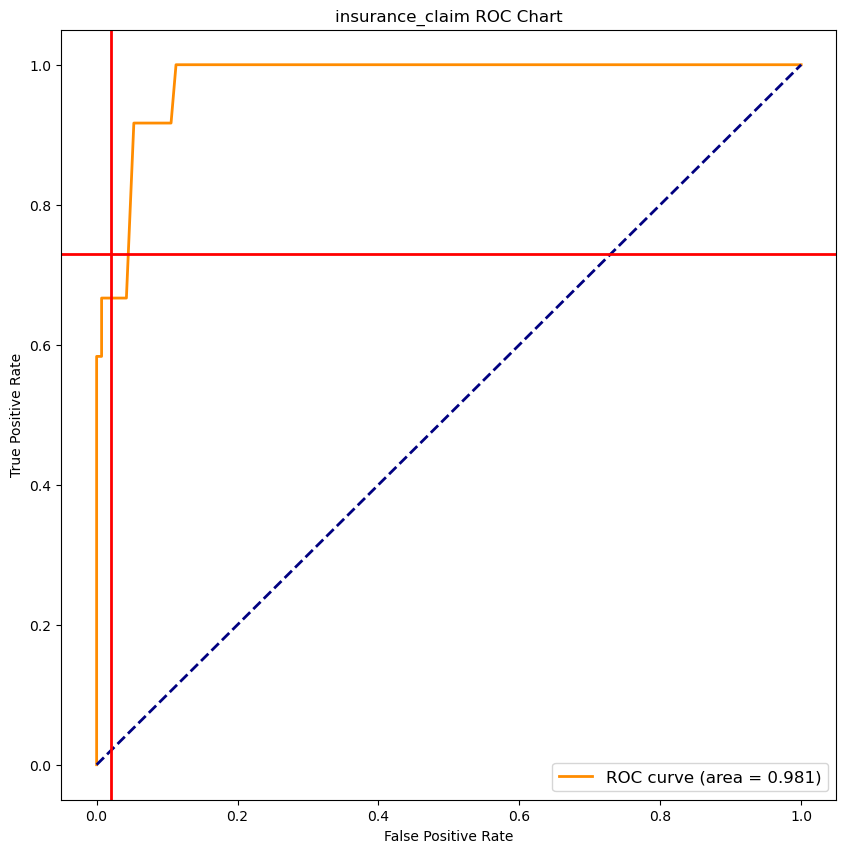

In [10]:
MODEL_NAME = 'insurance_claim'
DETECTOR_NAME = 'insurance_fraud_detector'
EVENT_TYPE = 'new_claim'
ENTITY_TYPE = 'customer'



# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

## Provide Test record

In [12]:
eventId = '668c6044-4949-47f1-abf0-02473c981950'
timestampStr = '2022-10-15T08:42:19Z'

# Construct a sample data record

rec = {
   'policy_id': '668c6044-4949-47f1-abf0-02473c981950',
   'incident_type': 'collision',
   'num_vehicles_involved' : '1',
   'num_witnesses' : '3',
   'injury_claim' : '6778',
   'incident_severity' :'6',
   'num_claims_past_year' : '4',
   'policy_deductable' :'805',
    'policy_annual_premium' :'2526',
    'incident_hour' : '12',
    'vehicle_claim' : '2673',
    'num_injuries' : '3'
}



pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId)}],
                                       eventVariables=rec)

In [13]:
pred

{'modelScores': [{'modelVersion': {'modelId': 'insurance_claim',
    'modelType': 'ONLINE_FRAUD_INSIGHTS',
    'modelVersionNumber': '1.0'},
   'scores': {'insurance_claim_insightscore': 1000.0}}],
 'ruleResults': [{'ruleId': 'auto-fraud-rule', 'outcomes': ['red']}],
 'externalModelOutputs': [],
 'ResponseMetadata': {'RequestId': '526db278-363c-43d5-8832-f4efcff955d6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 02 Aug 2023 19:17:30 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '266',
   'connection': 'keep-alive',
   'x-amzn-requestid': '526db278-363c-43d5-8832-f4efcff955d6'},
  'RetryAttempts': 0}}

In [15]:
# Extract/print the model score
pred['modelScores'][0]['scores']['insurance_claim_insightscore']

1000.0

## Create task UI
This can be done using the template below and adjusting depending on your use case.

In [16]:
template="""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
      <crowd-classifier
          name="category"
          categories="['Fradulent', 'Valid', 'Needs furthur review']"
          header="Select the most relevant category"
      >
      <classification-target>
        <h3><strong>Risk Score (out of 1000): </strong><span style="color: #ff9900;">{{ task.input.score.insurance_claim_insightscore }}</span></h3>
        <hr>
        <h3> Claim Details </h3>
        <p style="padding-left: 50px;"><strong>Policy_id :  </strong>{{ task.input.taskObject.policy_id }}</p>
        <p style="padding-left: 50px;"><strong>Incident Type :  </strong>{{ task.input.taskObject.incident_type }}</p>
        <p style="padding-left: 50px;"><strong>Number of vehichles involved :  </strong>{{ task.input.taskObject.num_vehichles_involved }}</p>
        <p style="padding-left: 50px;"><strong>number of witnesses :  </strong>{{ task.input.taskObject.num_witnesses }}</p>
        <p style="padding-left: 50px;"><strong>Injury claim:  </strong>{{ task.input.taskObject.injury_claim }}</p>
        <p style="padding-left: 50px;"><strong>Incident severity  :  </strong>{{ task.input.taskObject.incident_severity }}</p>
        <p style="padding-left: 50px;"><strong>Number of claims in past year :  </strong>{{ task.input.taskObject.num_claims_past_year }}</p>
        <p style="padding-left: 50px;"><strong>Policy deductable  :  </strong>{{ task.input.taskObject.policy_deductable }}</p>
        <p style="padding-left: 50px;"><strong>Policy annual premium      :  </strong>{{ task.input.taskObject.policy_annual_premium }}</p>
        <p style="padding-left: 50px;"><strong>Incident hour      :  </strong>{{ task.input.taskObject.incident_hour }}</p>
        <p style="padding-left: 50px;"><strong>Vehicle claim      :  </strong>{{ task.input.taskObject.vehicle_claim }}</p>
        <p style="padding-left: 50px;"><strong>Number of injuries :  </strong>{{ task.input.taskObject.num_injuries }}</p>
      </classification-target>
      
      <full-instructions header="Verification instructions">
      <ol>
        <li><strong>Review</strong> the claim and documents carefully.</li>
        <li>Mark the document as valid/fraudulent or needs furthur review </li>
      </ol>
      </full-instructions>

      <short-instructions>
           Choose the most relevant category that is expressed by the text. 
      </short-instructions>
    </crowd-classifier>

</crowd-form>
"""

In [17]:
def create_task_ui(task_ui_name, template):
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=task_ui_name,
        UiTemplate={'Content': template})
    return response

In [14]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'fraud-claim-ui'

# Create task UI
humanTaskUiResponse = create_task_ui(taskUIName, template)
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
uiArn = 'arn:aws:sagemaker:us-east-2:767819814815:human-task-ui/project-fraud-claim-template'
print(humanTaskUiArn)

NameError: name 'create_task_ui' is not defined

## Create flow defenition

In [19]:
OUTPUT_PATH = 's3://project-a2i-output/review-results/'
uiArn = 'arn:aws:sagemaker:us-east-2:767819814815:human-task-ui/project-fraud-claim-template'

def create_flow_definition(flow_definition_name):
    '''
    Creates a Flow Definition resource

    Returns:
    struct: FlowDefinitionArn
    '''
    response = sagemaker.create_flow_definition(
            FlowDefinitionName= flow_definition_name,
            RoleArn= ROLE,
            HumanLoopConfig= {
                "WorkteamArn": WORKTEAM_ARN,
                "HumanTaskUiArn": uiArn,
                "TaskCount": 1,
                "TaskDescription": "Please review the  data and flag for potential fraud",
                "TaskTitle": "Review and Approve / Reject Amazon Fraud detector predictions."
            },
            OutputConfig={
                "S3OutputPath" : OUTPUT_PATH
            }
        )
    
    return response['FlowDefinitionArn']

In [20]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
#uniqueId = str(uuid.uuid4())
uniqueId = str(int(round(time.time() * 1000)))
flowDefinitionName = f'project-fraud-detector-a2i-demo-{uniqueId}'
#flowDefinitionName = 'fraud-detector-a2i' 

flowDefinitionArn = create_flow_definition(flowDefinitionName)
print(flowDefinitionArn)

arn:aws:sagemaker:us-east-2:767819814815:flow-definition/project-fraud-detector-a2i-demo-1691167733686


# Start human loop depending on model score

In [32]:
OUTPUT_PATH = 's3://project-a2i-output/review-results/'

FraudScore= pred['modelScores'][0]['scores']['insurance_claim_insightscore']
print(FraudScore)

SCORE_THRESHOLD = 900
if FraudScore > SCORE_THRESHOLD :

    # Create the human loop input JSON object
    humanLoopInput = {
        'score' : pred['modelScores'][0]['scores'],
        'taskObject': rec
    }

print(json.dumps(humanLoopInput))


1000.0
{"score": {"insurance_claim_insightscore": 1000.0}, "taskObject": {"policy_id": "668c6044-4949-47f1-abf0-02473c981950", "incident_type": "collision", "num_vehicles_involved": "1", "num_witnesses": "3", "injury_claim": "6778", "incident_severity": "6", "num_claims_past_year": "4", "policy_deductable": "805", "policy_annual_premium": "2526", "incident_hour": "12", "vehicle_claim": "2673", "num_injuries": "3"}}


# Start loop

In [33]:
humanLoopName = 'Fraud-detector-' + str(int(round(time.time() * 1000)))
print('Starting human loop - ' + humanLoopName)

response = a2i_runtime_client.start_human_loop(
                            HumanLoopName=humanLoopName,
                            FlowDefinitionArn= flowDefinitionArn,
                            HumanLoopInput={
                                'InputContent': json.dumps(humanLoopInput)
                                }
                            )

Starting human loop - Fraud-detector-1691073816853


# Check status

In [34]:
all_human_loops_in_workflow = a2i_runtime_client.list_human_loops(FlowDefinitionArn=flowDefinitionArn)['HumanLoopSummaries']

for human_loop in all_human_loops_in_workflow:
    print(f'\nHuman Loop Name: {human_loop["HumanLoopName"]}')
    print(f'Human Loop Status: {human_loop["HumanLoopStatus"]} \n')
    print('\n')


Human Loop Name: Fraud-detector-1691073816853
Human Loop Status: InProgress 




Human Loop Name: Fraud-detector-1691010426620
Human Loop Status: Completed 



